In [1]:
import sys
sys.path.append('fashion-mnist')

from utils.mnist_reader import load_mnist

X_train, y_train = load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = load_mnist('fashion-mnist/data/fashion', kind='t10k')

In [2]:
import numpy as np
import seaborn as sns
from random import shuffle
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm

In [3]:
val_size = int(len(X_train)*0.1)

idx = np.arange(len(X_train))
shuffle(idx)
X_train, y_train = X_train[idx], y_train[idx]
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(54000, 784) (54000,)
(6000, 784) (6000,)
(10000, 784) (10000,)


<Axes: >

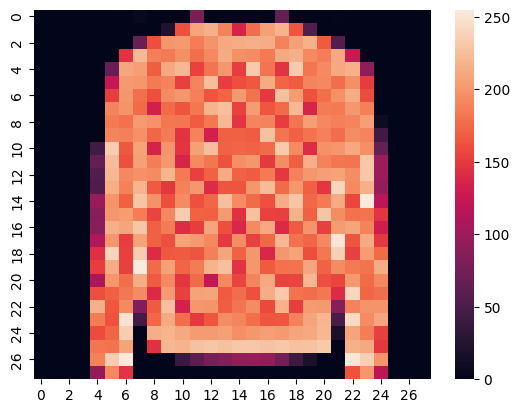

In [4]:
sns.heatmap(X_train[np.random.randint(len(X_train))].reshape(28, 28))

In [5]:
class Parameter:
    def __init__(self, data: np.ndarray, grad: np.ndarray=None):
        self.data = data
        self.grad = grad
        
    def __repr__(self):
        return f"Parameter(data={self.data}, grad={self.grad})"

class Module:
    def __init__(self, **parameters: Dict[str, Parameter]):
        self.parameters: Dict[str, Parameter] = parameters
    
    def __call__(self, *inputs):
        self._inputs = inputs
        self._outputs = self.forward(*inputs)
        return self._outputs

In [6]:
class Linear(Module):
    def __init__(self, input_features: int, output_features: int):
        self.w = Parameter(np.random.randn(input_features, output_features) * 0.01)
        self.b = Parameter(np.zeros(output_features))
        super().__init__(w=self.w, b=self.b)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        return X @ self.w.data + self.b.data
    
    def backward(self, grad_output: np.ndarray):
        X = self._inputs[0]
        self.w.grad = X.T @ grad_output
        self.b.grad = grad_output.sum(axis=0)

In [7]:
def softmax(z: np.ndarray) -> np.ndarray:
    ez = np.exp(z - z.max(axis=-1, keepdims=True))
    return ez / ez.sum(axis=-1, keepdims=True)

def accuracy(preds: np.ndarray, targets: np.ndarray) -> float:
    return (preds == targets).mean()

In [8]:
class Loss(Module):
    def forward(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
        logits -= logits.max(axis=-1, keepdims=True)
        return (np.log(np.sum(np.exp(logits), axis=-1)) - logits[np.arange(len(y)), y]).mean()
    
    def backward(self, _) -> np.ndarray:
        logits, y = self._inputs
        grads = softmax(logits)
        grads[np.arange(len(y)), y] -= 1
        return grads / len(y)

In [9]:
class SGD:
    def __init__(self, params: List[Parameter], lr: float):
        self.params = params
        self.lr = lr
        
    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad
            
    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [10]:
input_features = 784
output_classes = 10
batch_size = 32
lr = 0.03
num_epochs = 10

model = Linear(input_features, output_classes)
loss_fn = Loss()
optim = SGD(list(model.parameters.values()), lr=lr)

In [11]:
def data_loader(data: Tuple, batch_size: int, train: bool=False):
    if train:
        idx = np.arange(len(X_train))
        shuffle(idx)
        data = [x[idx] for x in data]
        
    for i in range(0, len(data[0]), batch_size):
        yield tuple(x[i:i+batch_size] for x in data)
        
def prepare_inputs(X: np.ndarray):
    return (X / 255) - 0.5

def train_epoch(pbar):
    pbar.total = len(X_train)
    train_loss = 0
    num_train_samples = 0
    for X, y in data_loader((X_train, y_train), batch_size, True):
        loss = loss_fn(model(prepare_inputs(X)), y)

        optim.zero_grad()
        model.backward(loss_fn.backward(None))
        optim.step()

        train_loss += (loss * len(X)).item()
        num_train_samples += len(X)
        pbar.update(len(X))
        pbar.set_postfix({"train_loss": train_loss / num_train_samples})
        
    return train_loss / num_train_samples
        

def val_epoch(pbar):
    pbar.total = len(X_val)
    val_loss = 0
    num_val_samples = 0
    preds = []
    for X, y in data_loader((X_val, y_val), batch_size, False):
        outputs = model(prepare_inputs(X))
        loss = loss_fn(outputs, y)
        preds += outputs.argmax(axis=-1).tolist()

        val_loss += (loss * len(X)).item()
        num_val_samples += len(X)
        pbar.update(len(X))
        pbar.set_postfix({"val_loss": val_loss / num_val_samples, "accuracy": accuracy(np.asarray(preds), y_val[:num_val_samples])})
        
    return val_loss / num_val_samples, accuracy(np.asarray(preds), y_val[:num_val_samples])

In [12]:
with tqdm(desc="Val", leave=False) as pbar:
    val_loss, val_accuracy = val_epoch(pbar)

print(f"Initial: {val_loss=}, {val_accuracy}")

for epoch in range(num_epochs):
    with tqdm(desc="Train", leave=False) as pbar:
        train_loss = train_epoch(pbar)

    with tqdm(desc="Val", leave=False) as pbar:
        val_loss, val_accuracy = val_epoch(pbar)
        
    print(f"Epoch {epoch}: {train_loss=}, {val_loss=}, {val_accuracy}")

Val: 0it [00:00, ?it/s]

Initial: val_loss=2.326256309968825, 0.06066666666666667


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 0: train_loss=0.6414789936447342, val_loss=0.524257789725819, 0.8211666666666667


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 1: train_loss=0.49941291502877894, val_loss=0.48139633047275865, 0.8348333333333333


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 2: train_loss=0.47058478984052776, val_loss=0.46239227355317597, 0.8376666666666667


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 3: train_loss=0.4551791304644738, val_loss=0.4500517203756088, 0.845


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 4: train_loss=0.4445768766552856, val_loss=0.44860874317326016, 0.8448333333333333


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 5: train_loss=0.4372443531378618, val_loss=0.44627252872755935, 0.8413333333333334


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 6: train_loss=0.4315644646953359, val_loss=0.43694792777153196, 0.8446666666666667


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 7: train_loss=0.42664098732248706, val_loss=0.4320982109757885, 0.8481666666666666


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 8: train_loss=0.42228830987695065, val_loss=0.4317760628133527, 0.8491666666666666


Train: 0it [00:00, ?it/s]

Val: 0it [00:00, ?it/s]

Epoch 9: train_loss=0.4192536371520857, val_loss=0.4284362529347051, 0.8511666666666666
